In [33]:
%load_ext autoreload
%autoreload 2


from ff_energy.ffe.slurm import SlurmJobHandler
from pathlib import Path
import pandas as pd
import jax.numpy as jnp
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import patchworklib as pw


from ff_energy.ffe.potential import (
    LJ,
    DE,
)

from ff_energy.ffe.ff import FF
from ff_energy.ffe.constants import FFEPATH
from ff_energy.plotting.ffe_plots import plot_energy_MSE, plot_ff_fit

from ff_energy.plotting.plotting import set_style, patchwork_grid, save_fig


from ff_energy.plotting.fit_results import (
    residuals_plot, simple_residuals_plot, residuals_from_keys
)

from ff_energy.logs.logging import hide_logs

from ff_energy.ffe.potential import LJ, LJ_bound, DE


hide_logs()


import scienceplots
set_style(no_latex=True)

# sns.set_style()
# plt.style.use(["science", "no-latex"])


from ff_energy.ffe.ff_fit import (
    load_ff,
    fit_func,
    fit_repeat,
)

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, PKL_PATH
from ff_energy.utils.json_utils import load_json

from ff_energy.ffe.structure import atom_key_pairs


structure_data = {
    "dcm": "",
    "water_cluster": PKL_PATH / "20230823_water_clusters.pkl.pkl",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def make_paper_fig(system, key=None, exclusions=None, stripAxes=False, ticks=None):
    if exclusions is None:
        exclusions = []
    if key is None:
        key = system.lower()
    intE_label = "PBE0 Energy [kcal/mol]"
    FFintE_label = "FF Energy [kcal/mol]"

    elec_label_keys = {
        'ELECci': "Coloumb",
        'ELECp': "PC Fit",
        'ELECm': "MDCM",
        'ELECk': "kMDCM",
        'ELECnull': "No electrostatics",
        'ELECnullpol': "Only Many-Body Polarization",
        'ELECpol': "Polarization",
        'ELECci': "Coloumb Integral",
        'ELECppol': "PC Fit + Polarization",
        'ELECmpol': "MDCM + Polarization",
        'ELECkpol': "kMDCM + Polarization",
    }

    csv_files = list(PKL_PATH.glob(f"*{key}*elec.csv"))
    dataframes = {csv.name: pd.read_csv(csv) for csv in csv_files}
    names = [_.name for _ in csv_files if True not in [ex in _.name for ex in exclusions]]
    names.sort()
    dataframes = [dataframes[n] for n in names]
    names = [elec_label_keys[_.split("_")[0]] for _ in names]

    axes = []
    print(names)
    fig_lab = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"]

    for i in range(len(dataframes)):
        _title = fig_lab[i] # + names[i] 
        _ = simple_residuals_plot(dataframes[i], _title, 
                              xlabel=intE_label, ylabel=FFintE_label)
        axes.append(_)
        
    if stripAxes:
        axes[0].set_xlabel("")
        axes[1].set_xlabel("")
        axes[1].set_ylabel("")
        axes[3].set_ylabel("")
        
        if ticks is None:
            ticks = [-90, -75, -60, -45, -30]

        for _ in axes:
            _.set_xticks(ticks)
            _.set_yticks(ticks)
        
        
    figure = patchwork_grid(axes)
    figure.set_suptitle(system, x=0.55, y=1)
    
    return figure, axes


In [31]:
set_style()

In [27]:
import matplotlib as mpl
# mpl.rcParams.keys()

['Coloumb Integral', 'kMDCM', 'MDCM', 'PC Fit']


2023-09-18 15:10:51 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to load font
2023-09-18 15:10:51 | DEBUG | ttFont:_readTable:459 - Reading 'maxp' table from disk
2023-09-18 15:10:51 | DEBUG | ttFont:_readTable:468 - Decompiling 'maxp' table
2023-09-18 15:10:51 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'maxp'
2023-09-18 15:10:51 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'maxp'
2023-09-18 15:10:51 | INFO | __init__:_prune_pre_subset:3273 - maxp pruned
2023-09-18 15:10:51 | INFO | __init__:_prune_pre_subset:3257 - LTSH dropped
2023-09-18 15:10:51 | DEBUG | ttFont:_readTable:459 - Reading 'cmap' table from disk
2023-09-18 15:10:51 | DEBUG | ttFont:_readTable:468 - Decompiling 'cmap' table
2023-09-18 15:10:51 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'cmap'
2023-09-18 15:10:51 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'cmap'
2023-09-18 15:10:51 | INFO | __init__:_prune_pre_subset:3273 - cmap pruned
2023-09-18 15:10:51 |

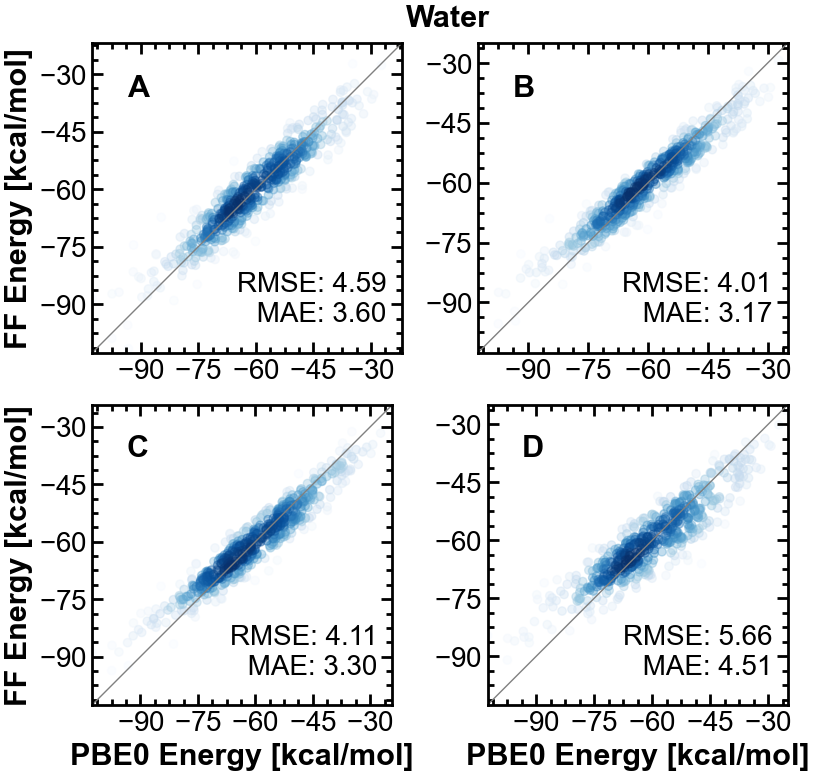

<Figure size 800x600 with 0 Axes>

In [34]:
water_fig, water_axes = make_paper_fig("Water", exclusions=["null", "pol", "MMintE"],
                                       stripAxes=True)
water_fig.savefig("water_ff.pdf")

['Coloumb Integral', 'kMDCM', 'No electrostatics', 'PC Fit']


2023-09-18 15:18:22 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to load font
2023-09-18 15:18:22 | DEBUG | ttFont:_readTable:459 - Reading 'maxp' table from disk
2023-09-18 15:18:22 | DEBUG | ttFont:_readTable:468 - Decompiling 'maxp' table
2023-09-18 15:18:22 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'maxp'
2023-09-18 15:18:22 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'maxp'
2023-09-18 15:18:22 | INFO | __init__:_prune_pre_subset:3273 - maxp pruned
2023-09-18 15:18:22 | INFO | __init__:_prune_pre_subset:3257 - LTSH dropped
2023-09-18 15:18:22 | DEBUG | ttFont:_readTable:459 - Reading 'cmap' table from disk
2023-09-18 15:18:22 | DEBUG | ttFont:_readTable:468 - Decompiling 'cmap' table
2023-09-18 15:18:22 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'cmap'
2023-09-18 15:18:22 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'cmap'
2023-09-18 15:18:22 | INFO | __init__:_prune_pre_subset:3273 - cmap pruned
2023-09-18 15:18:22 |

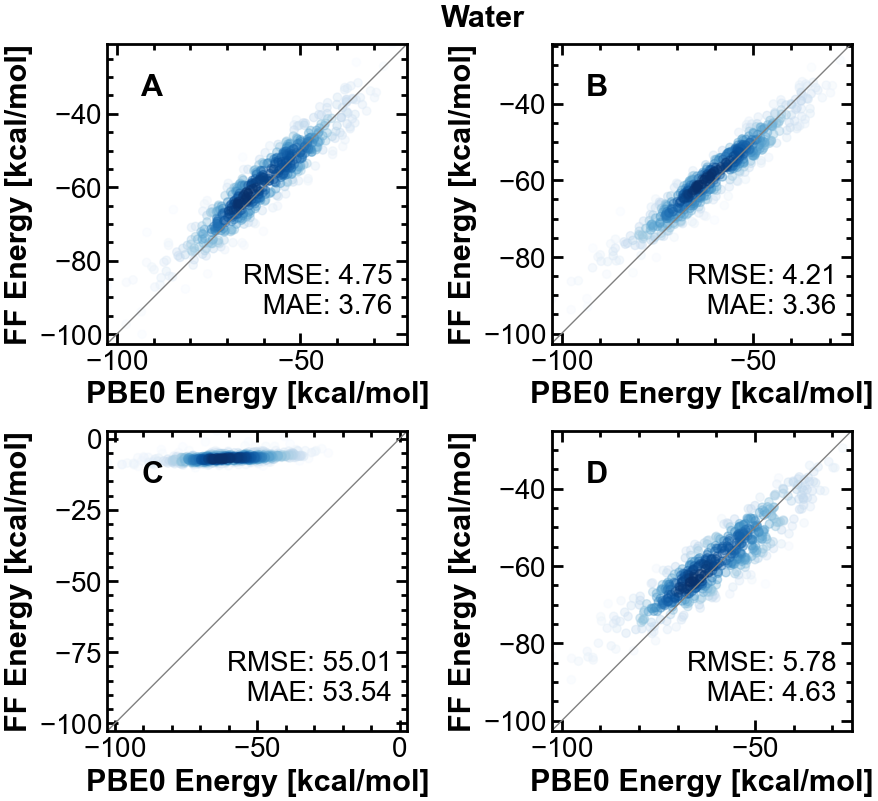

<Figure size 800x600 with 0 Axes>

In [41]:
water_fig, water_axes = make_paper_fig("Water", key="MMintE", exclusions=["pol",],
                                       stripAxes=False)
water_fig.savefig("water_ff.pdf")

['kMDCM + Polarization', 'MDCM + Polarization', 'Polarization', 'PC Fit + Polarization']


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-15 17:31:12 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-15 17:31:12 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-15 17:31:12 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-15 17:31:12 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-15 17:31:12 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:to

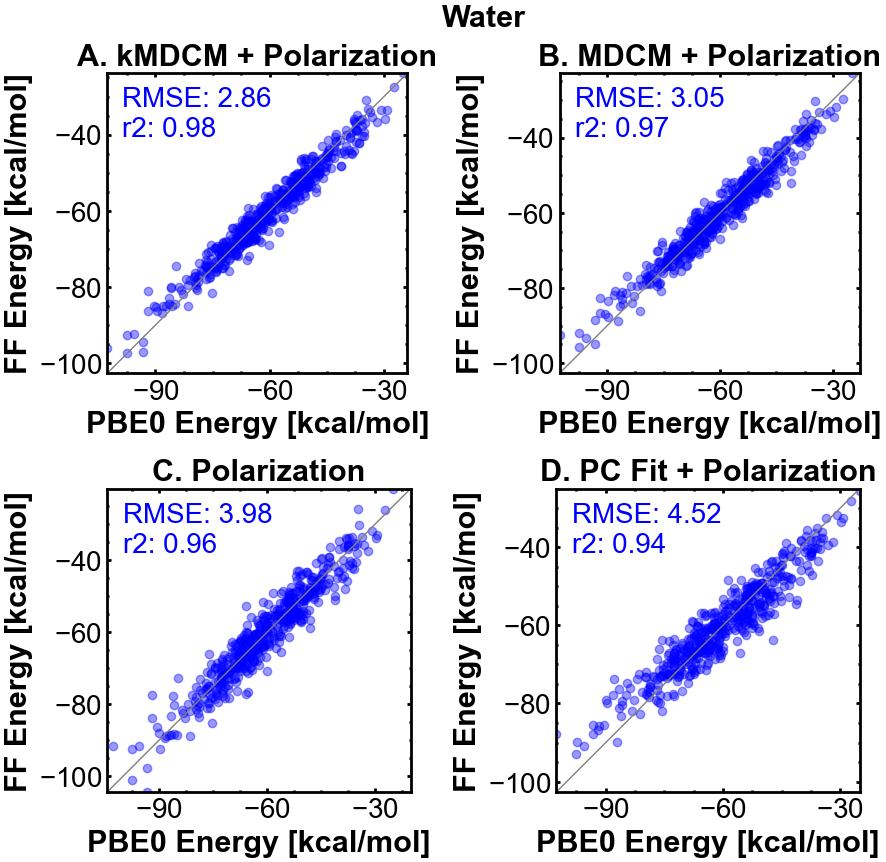

In [36]:
water_fig, water_axes = make_paper_fig("Water", key="pol*water", exclusions=["null"])
water_fig.savefig("water_pol.pdf")

['Coloumb Integral', 'MDCM', 'No electrostatics', 'PC Fit']


2023-09-18 15:13:02 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to load font
2023-09-18 15:13:02 | DEBUG | ttFont:_readTable:459 - Reading 'maxp' table from disk
2023-09-18 15:13:02 | DEBUG | ttFont:_readTable:468 - Decompiling 'maxp' table
2023-09-18 15:13:02 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'maxp'
2023-09-18 15:13:02 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'maxp'
2023-09-18 15:13:02 | INFO | __init__:_prune_pre_subset:3273 - maxp pruned
2023-09-18 15:13:02 | INFO | __init__:_prune_pre_subset:3257 - LTSH dropped
2023-09-18 15:13:02 | DEBUG | ttFont:_readTable:459 - Reading 'cmap' table from disk
2023-09-18 15:13:02 | DEBUG | ttFont:_readTable:468 - Decompiling 'cmap' table
2023-09-18 15:13:02 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'cmap'
2023-09-18 15:13:02 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'cmap'
2023-09-18 15:13:02 | INFO | __init__:_prune_pre_subset:3273 - cmap pruned
2023-09-18 15:13:02 |

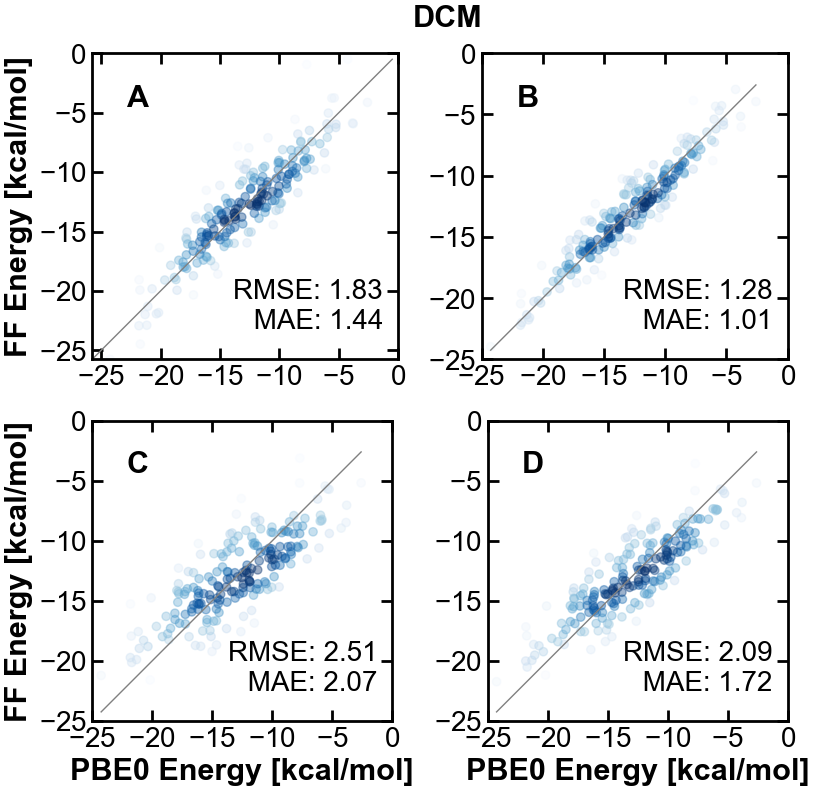

<Figure size 800x600 with 0 Axes>

In [39]:
fig, axes = make_paper_fig("DCM", exclusions=["pol"], ticks=[0, -5, -10, -15, -20, -25], stripAxes=True)
fig.savefig("dcm_ff.pdf")

['MDCM + Polarization', 'Only Many-Body Polarization', 'Polarization', 'PC Fit + Polarization']


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-15 17:31:15 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-15 17:31:15 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-15 17:31:15 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-15 17:31:15 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-15 17:31:16 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:to

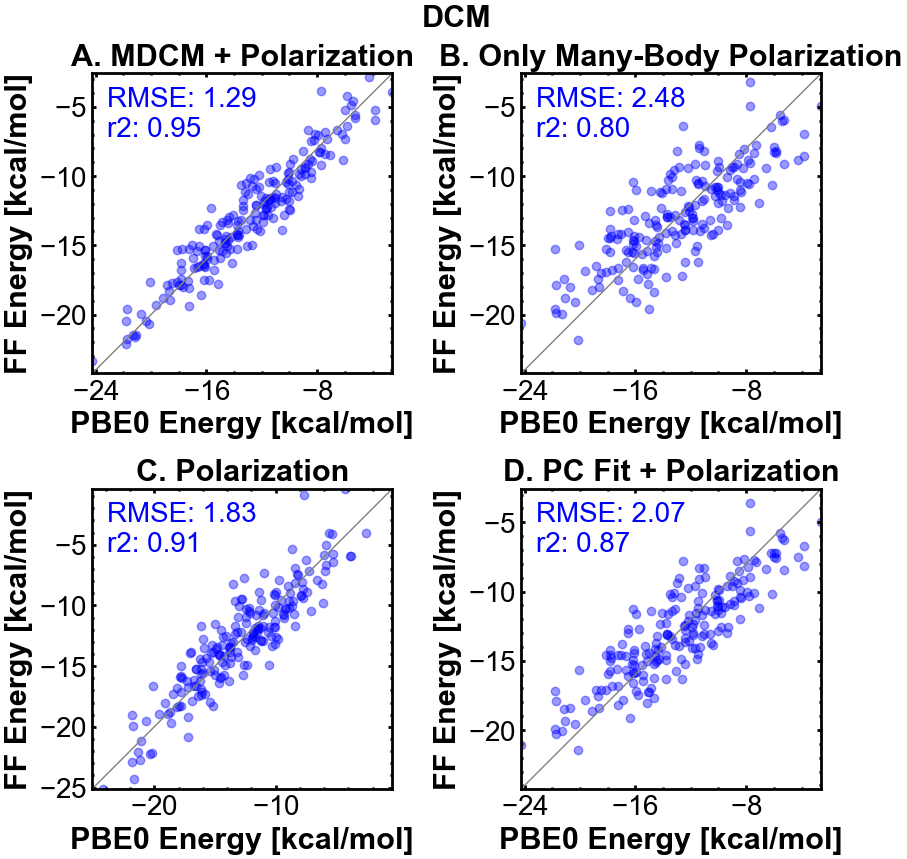

In [38]:
fig, axes = make_paper_fig("DCM", key="pol*dcm", exclusions=[])
fig.savefig("dcm_pol.pdf")

2023-09-15 14:44:18 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to load font
2023-09-15 14:44:18 | DEBUG | ttFont:_readTable:459 - Reading 'maxp' table from disk
2023-09-15 14:44:18 | DEBUG | ttFont:_readTable:468 - Decompiling 'maxp' table
2023-09-15 14:44:18 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'maxp'
2023-09-15 14:44:18 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'maxp'
2023-09-15 14:44:18 | INFO | __init__:_prune_pre_subset:3273 - maxp pruned
2023-09-15 14:44:18 | DEBUG | ttFont:_readTable:459 - Reading 'cmap' table from disk
2023-09-15 14:44:18 | DEBUG | ttFont:_readTable:468 - Decompiling 'cmap' table
2023-09-15 14:44:18 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'cmap'
2023-09-15 14:44:18 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'cmap'
2023-09-15 14:44:18 | INFO | __init__:_prune_pre_subset:3273 - cmap pruned
2023-09-15 14:44:18 | DEBUG | ttFont:_readTable:459 - Reading 'post' table from disk
2023-09-15 1

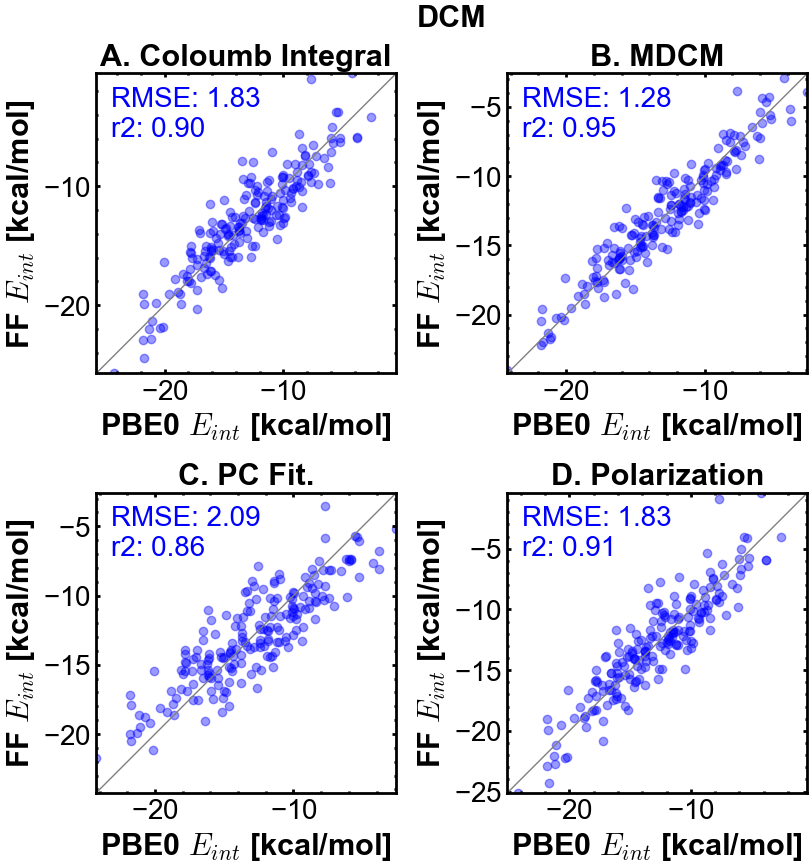

In [145]:
# dcm_fig.savefig("dcm_fit.pdf")

In [ ]:
# water_fig = make_paper_fig("Water")